In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [27]:
# MPC import
import numpy as np
from LinearMPC_template.MPCVelControl import MPCVelControl
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis
from src.vel_rocket_vis import plot_static_states_inputs


rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")


In [14]:
Ts = 0.05
sim_time = 20
H = 10
# x0 = np.zeros(12) # initial state
# x0[5] = np.deg2rad(30.0)   # ≈ 0.5236 
# x0[6] = 5.0  # initial vx
# x0[7] = 5.0  # initial vy
# x0[8] = 5.0  # initial vz# initial wy
#on doit changer un des parametres de xo pour mettre une vitesse dans la direction voulue 
# X -> Xo(6) = Vx, Y-> XO(7) = Vy, Z-> Xo(8) = Vz

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()
x0 = xs.copy()
x0[5] = np.deg2rad(30)
x0[6] = 5.0  # initial vx
x0[7] = 5.0  # initial vy
x0[8] = 5.0  # initial vz# initial wy
xs, us = rocket.trim()
print("us =", us)
print("Pdiff trim us[3] =", us[3])
mpc = MPCVelControl().new_controller(rocket, Ts, H)



t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, method="linear"
)


vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol);

us = [ 0.          0.         66.66666667  0.        ]
Pdiff trim us[3] = 0.0
['A', 'H', 'b']
['A', 'H', 'b']
Simulating time 0.00: u_x: [0.26179985]
u_y: [-0.26180008]
u_z: [39.99999999]
u_roll: [-8.93100659]

Simulating time 0.05: u_x: [0.06890143]
u_y: [-0.26179802]
u_z: [40.00002993]
u_roll: [-7.75603584]

Simulating time 0.10: u_x: [-0.06285633]
u_y: [0.24880283]
u_z: [40.00001654]
u_roll: [-6.69581413]

Simulating time 0.15: u_x: [-0.11055388]
u_y: [0.26061868]
u_z: [40.00002446]
u_roll: [-5.7407089]

Simulating time 0.20: u_x: [-0.10598255]
u_y: [0.02668767]
u_z: [40.00001269]
u_roll: [-4.8816046]

 State alpha violation: 0.17 > 0.17, 
Simulating time 0.25: u_x: [-0.05148389]
u_y: [-0.01980346]
u_z: [40.00002094]
u_roll: [-4.11007457]

 State alpha violation: 0.17 > 0.17, 
Simulating time 0.30: u_x: [0.20697556]
u_y: [0.0117266]
u_z: [40.00001021]
u_roll: [-3.41842024]

 State beta violation: -0.17 < -0.17, 
Simulating time 0.35: u_x: [0.06175038]
u_y: [-0.00697744]
u_z: [40.000

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=399, step=2), IntSlider(value=0…

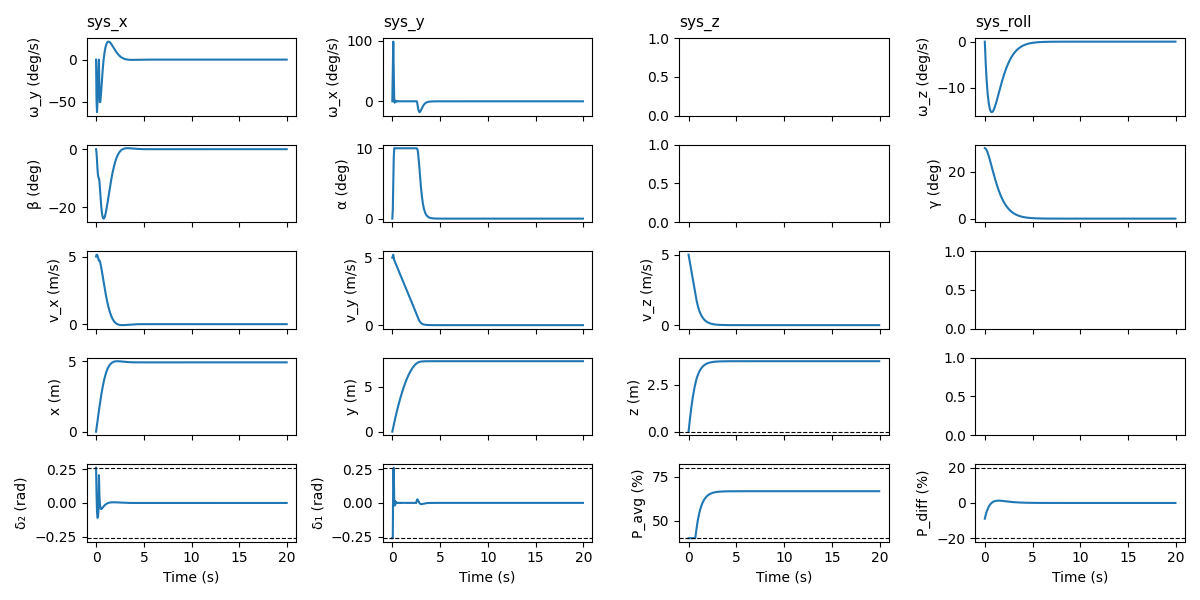

In [33]:
plot_static_states_inputs(
    T=t_cl[:-1],      # time for inputs
    X=x_cl[:, :-1],   # match the same length
    U=u_cl,           # DON'T slice
    Ref=None,
    type="vel"
)



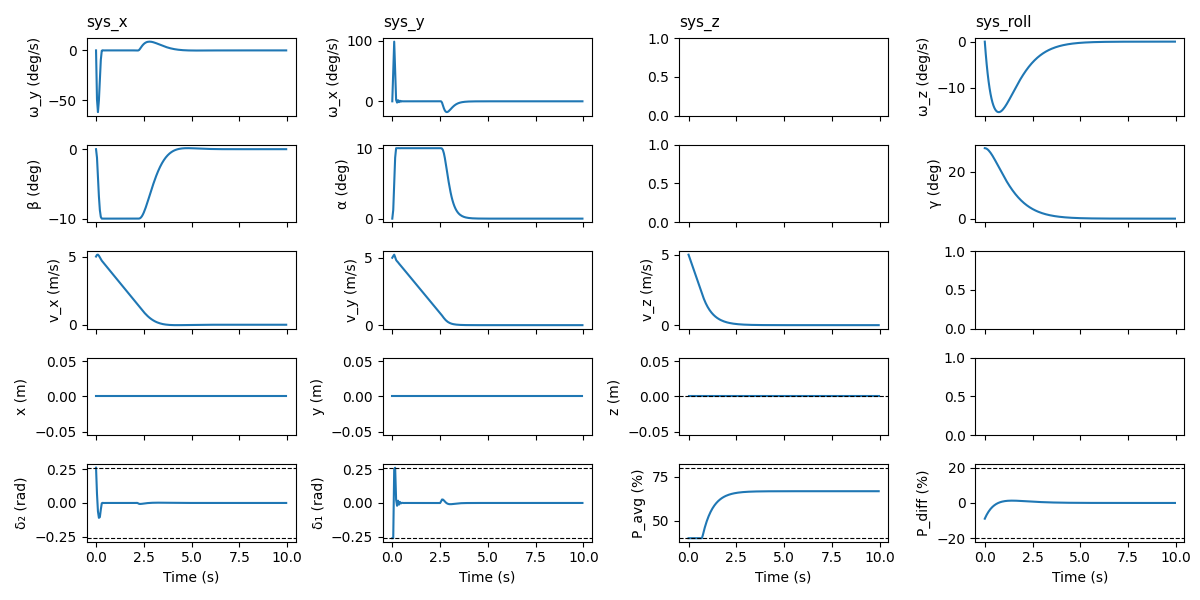

In [35]:
from src.vel_rocket_vis import plot_static_states_inputs

k = 0
T_ol = t_ol[:, k]      # shape (H+1,)
X_ol = x_ol[:, :, k]   # shape (12, H+1)
U_ol = u_ol[:, :, k]   # shape (4, H)

plot_static_states_inputs(
    T=T_ol[:-1],
    X=X_ol[:, :-1],
    U=U_ol,
    Ref=None,
    type="vel"
)


In [4]:
from LinearMPC_template.MPCControl_xvel import MPCControl_xvel
xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)
mpc_x = MPCControl_xvel(A, B, xs, us, Ts, H) # Full 12x12 A and 12x4 B matrices
x0_sub = x0[mpc_x.x_ids]   # shape (3,)
u0, x_traj, u_traj = mpc_x.get_u(x0_sub)


['A', 'H', 'b']
['A', 'H', 'b']


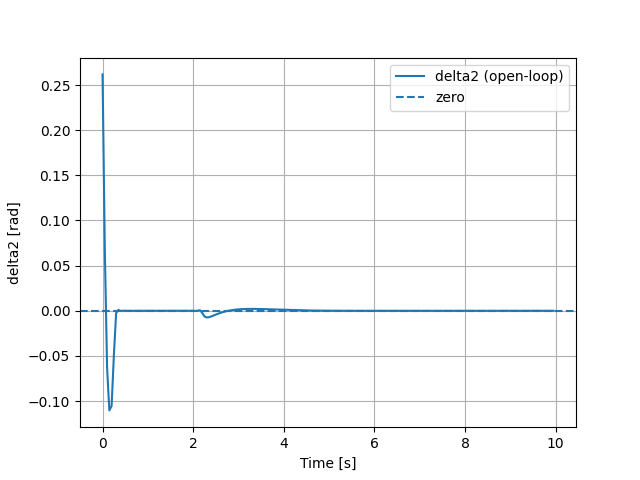

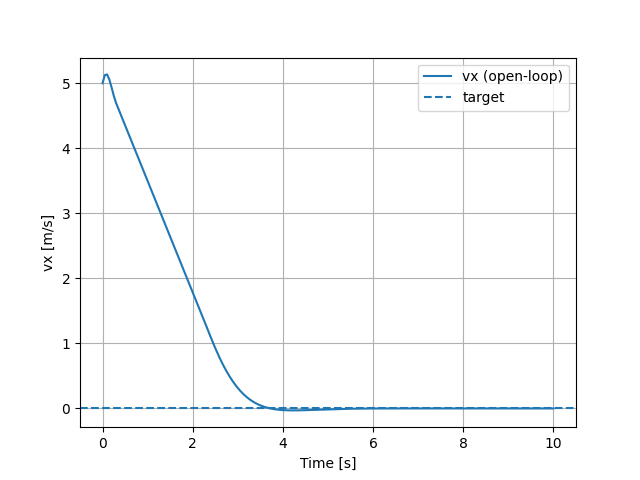

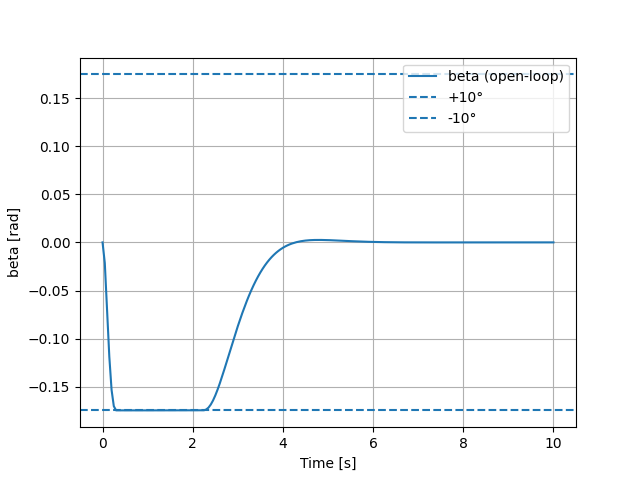

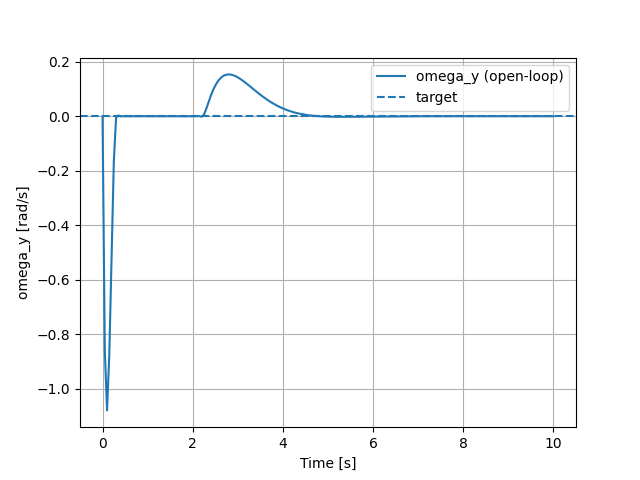

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_x_open_loop(mpc_x, x_traj, u_traj):
    Ts = mpc_x.Ts
    N = mpc_x.N
    t_x = np.arange(N + 1) * Ts
    t_u = np.arange(N) * Ts

    omega_y = x_traj[0, :]
    beta    = x_traj[1, :]
    vx      = x_traj[2, :]
    delta2  = u_traj[0, :]

    beta_max = np.deg2rad(10.0)

    plt.figure()
    plt.plot(t_x, vx, label="vx (open-loop)")
    plt.axhline(0.0, linestyle="--", label="target")
    plt.xlabel("Time [s]")
    plt.ylabel("vx [m/s]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_x, beta, label="beta (open-loop)")
    plt.axhline(+beta_max, linestyle="--", label="+10°")
    plt.axhline(-beta_max, linestyle="--", label="-10°")
    plt.xlabel("Time [s]")
    plt.ylabel("beta [rad]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_x, omega_y, label="omega_y (open-loop)")
    plt.axhline(0.0, linestyle="--", label="target")
    plt.xlabel("Time [s]")
    plt.ylabel("omega_y [rad/s]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_u, delta2, label="delta2 (open-loop)")
    plt.axhline(0.0, linestyle="--", label="zero")
    plt.xlabel("Time [s]")
    plt.ylabel("delta2 [rad]")
    plt.grid(True)
    plt.legend()

# call it
plot_x_open_loop(mpc_x, x_traj, u_traj)
plt.show()


In [6]:
from LinearMPC_template.MPCControl_yvel import MPCControl_yvel
xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)
mpc_y = MPCControl_yvel(A, B, xs, us, Ts, H) # Full 12x12 A and 12x4 B matrices
x0_sub = x0[mpc_y.x_ids]   # shape (3,)
u0, x_traj, u_traj = mpc_y.get_u(x0_sub)

c:\Users\SammD\anaconda3\envs\mpc2025\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


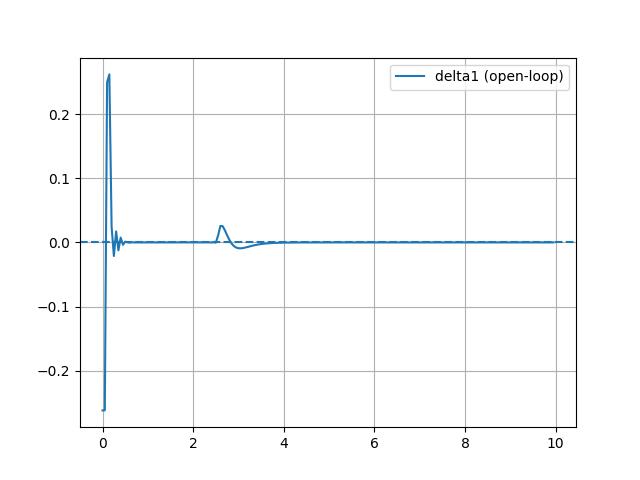

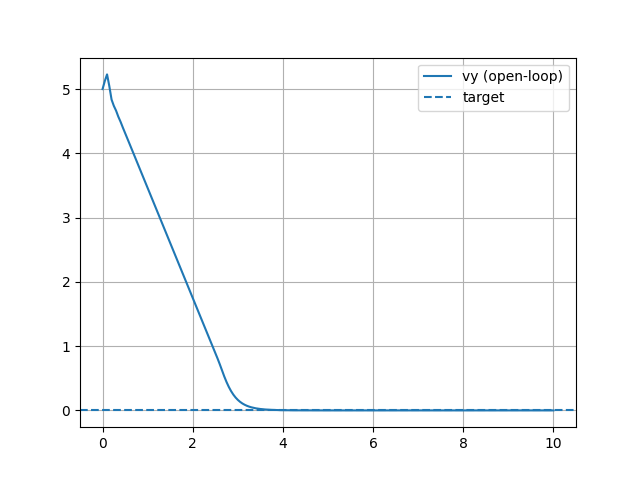

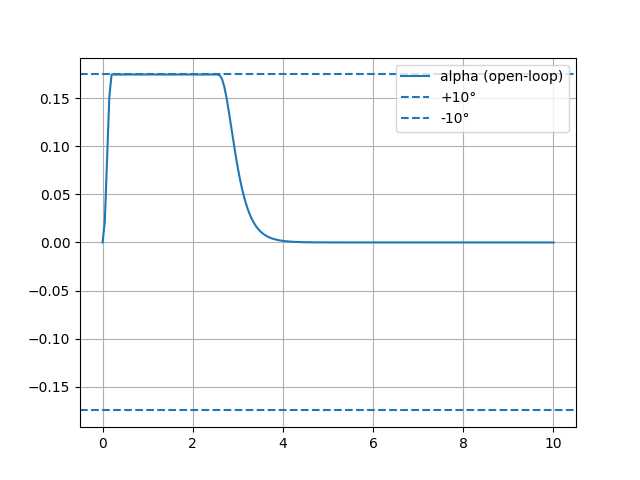

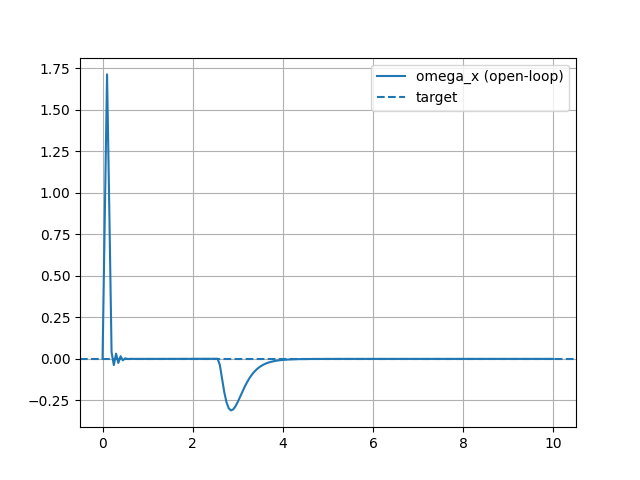

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_y_open_loop(mpc_y, x_traj, u_traj):
    Ts = mpc_y.Ts
    N = mpc_y.N
    t_x = np.arange(N + 1) * Ts
    t_u = np.arange(N) * Ts

    omega_x = x_traj[0, :]
    alpha   = x_traj[1, :]
    vy      = x_traj[2, :]
    delta1  = u_traj[0, :]

    alpha_max = np.deg2rad(10.0)

    plt.figure(); plt.plot(t_x, vy, label="vy (open-loop)")
    plt.axhline(0.0, linestyle="--", label="target"); plt.grid(True); plt.legend()

    plt.figure(); plt.plot(t_x, alpha, label="alpha (open-loop)")
    plt.axhline(+alpha_max, linestyle="--", label="+10°")
    plt.axhline(-alpha_max, linestyle="--", label="-10°")
    plt.grid(True); plt.legend()

    plt.figure(); plt.plot(t_x, omega_x, label="omega_x (open-loop)")
    plt.axhline(0.0, linestyle="--", label="target"); plt.grid(True); plt.legend()

    plt.figure(); plt.plot(t_u, delta1, label="delta1 (open-loop)")
    plt.axhline(0.0, linestyle="--"); plt.grid(True); plt.legend()

plot_y_open_loop(mpc_y, x_traj, u_traj)
plt.show()


In [8]:
from LinearMPC_template.MPCControl_zvel import MPCControl_zvel
xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)
mpc_z = MPCControl_zvel(A, B, xs, us, Ts, H) # Full 12x12 A and 12x4 B matrices
x0_sub = x0[mpc_z.x_ids]   # shape (3,)
u0, x_traj, u_traj = mpc_z.get_u(x0_sub)

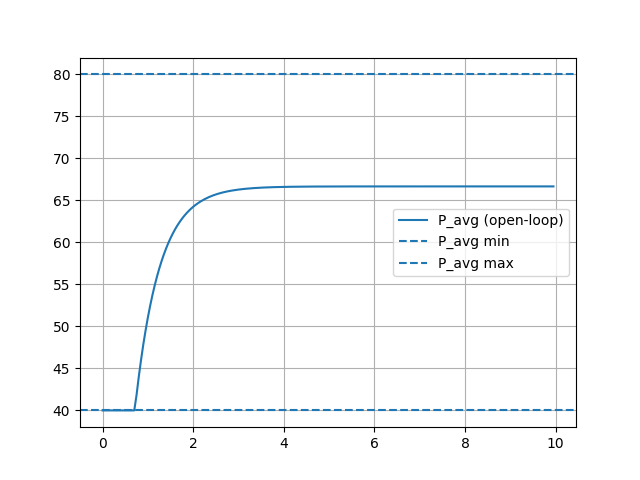

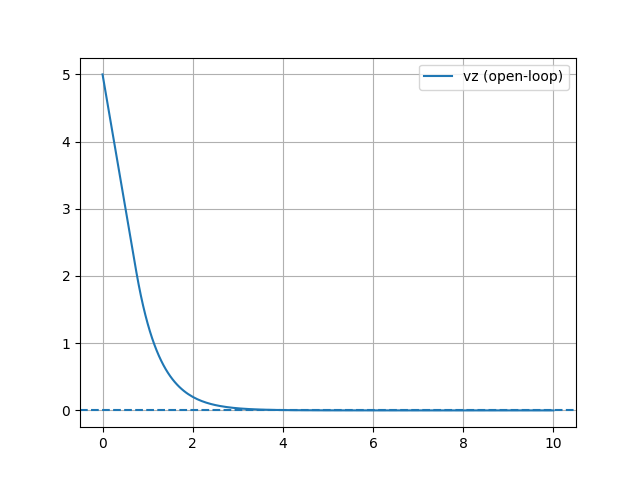

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_z_open_loop(mpc_y, x_traj, u_traj):
    Ts = mpc_y.Ts
    N = mpc_y.N
    t_x = np.arange(N + 1) * Ts
    t_u = np.arange(N) * Ts

    vz      = x_traj[0, :]
    P_avg  = u_traj[0, :]


    plt.figure(); 
    plt.plot(t_x, vz, label="vz (open-loop)")
    plt.axhline(0.0, linestyle="--"); plt.grid(True); plt.legend()


    plt.figure(); plt.plot(t_u, P_avg, label="P_avg (open-loop)")
    plt.axhline(40, linestyle="--", label="P_avg min"); plt.grid(True); plt.legend()
    plt.axhline(80, linestyle="--", label="P_avg max"); plt.grid(True); plt.legend()

plot_z_open_loop(mpc_y, x_traj, u_traj)
plt.show()


In [10]:
from LinearMPC_template.MPCControl_roll import MPCControl_roll
import numpy as np

xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)

mpc_roll = MPCControl_roll(A, B, xs, us, Ts, H)

# subsystem initial state
x0_sub = x0[mpc_roll.x_ids].copy()

# subsystem target: same as trim, except alpha (full-state index 3) -> 30°
xT_sub = mpc_roll.xs.copy()
if 3 in mpc_roll.x_ids:
    i_alpha = int(np.where(mpc_roll.x_ids == 3)[0][0])   # position of alpha inside subsystem state
    xT_sub[i_alpha] = np.deg2rad(30.0)

# input target: keep trim
uT_sub = mpc_roll.us.copy()

u0, x_traj, u_traj = mpc_roll.get_u(x0_sub, x_target=xT_sub, u_target=uT_sub)


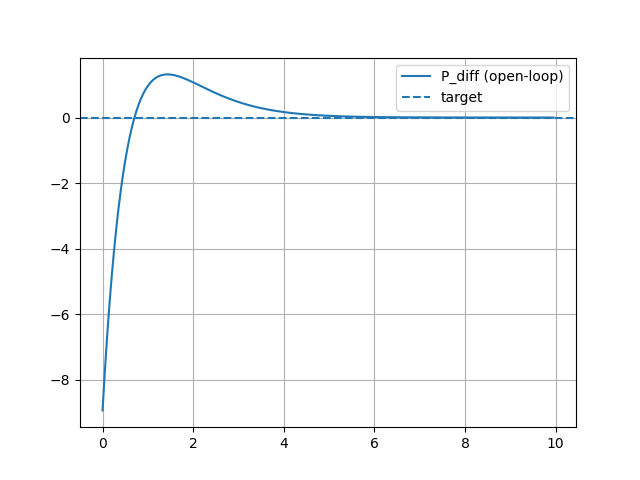

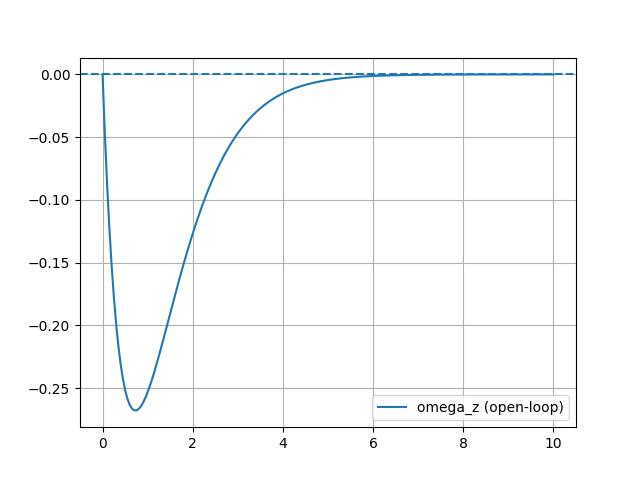

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

def plot_roll_open_loop(mpc_y, x_traj, u_traj):
    Ts = mpc_y.Ts
    N = mpc_y.N
    t_x = np.arange(N + 1) * Ts
    t_u = np.arange(N) * Ts

    omega_z    = x_traj[0, :]
    P_diff  = u_traj[0, :]


    plt.figure(); 
    plt.plot(t_x, omega_z, label="omega_z (open-loop)")
    plt.axhline(0.0, linestyle="--"); plt.grid(True); plt.legend()


    plt.figure(); plt.plot(t_u, P_diff, label="P_diff (open-loop)")
    plt.axhline(0, linestyle="--", label="target"); plt.grid(True); plt.legend()
    
plot_roll_open_loop(mpc_y, x_traj, u_traj)
plt.show()


In [12]:
import inspect
from mpt4py import Polyhedron
print(Polyhedron)
print(inspect.signature(Polyhedron))
print([m for m in dir(Polyhedron) if "proj" in m.lower() or "plot" in m.lower()])


<class 'mpt4py.geometry.polyhedron.Polyhedron'>
(H: Optional[mpt4py.base.HData] = None, V: Optional[mpt4py.base.VData] = None)
['plot', 'project', 'projection']


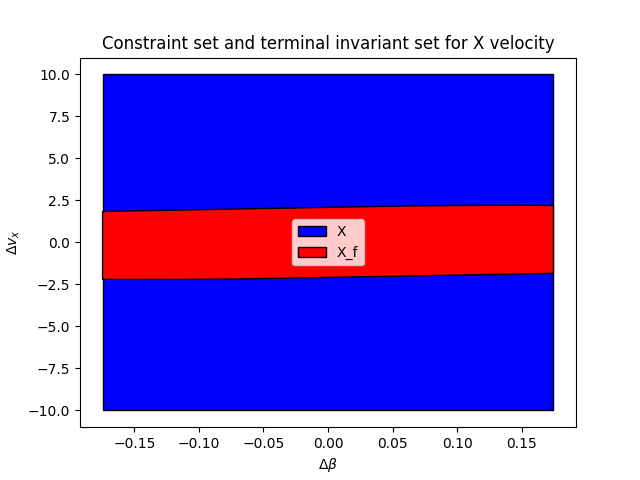

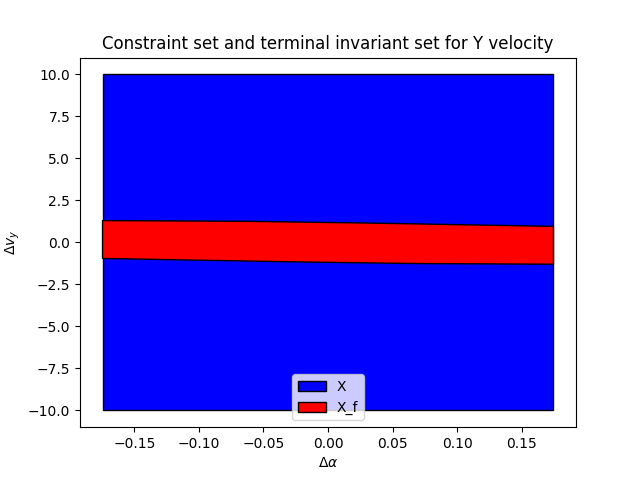

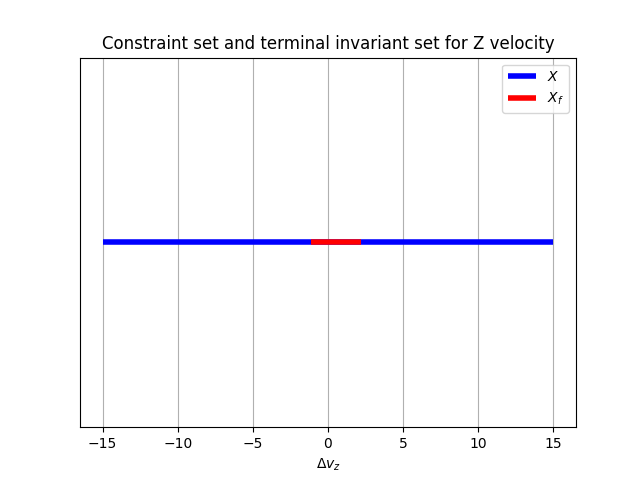

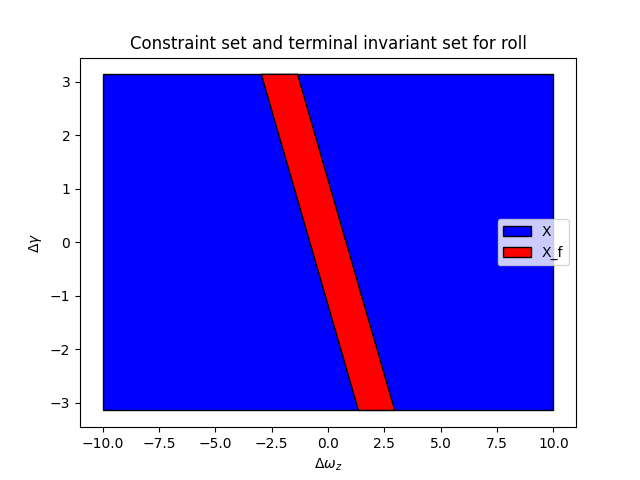

In [13]:
import matplotlib.pyplot as plt

P = [1, 2]  # indices in xvel state [ωy, β, vx] -> (β, vx)

Xproj_x  = mpc_x._X.projection(P)
Xfproj_x = mpc_x._Xf.projection(P)

fig, ax = plt.subplots()
Xproj_x.plot(ax=ax, color ="blue", label=r"X")     # state constraint set X (projected)
Xfproj_x.plot(ax=ax, color="red", label=r"X_f")    # terminal set (projected)

ax.set_title(r"Constraint set and terminal invariant set for X velocity")
ax.set_xlabel(r"$\Delta\beta$")
ax.set_ylabel(r"$\Delta v_x$")
plt.legend()
plt.show()



Xproj_y  = mpc_y._X.projection(P)
Xfproj_y = mpc_y._Xf.projection(P)



fig, ax = plt.subplots()
Xproj_y.plot(ax=ax, color ="blue", label=r"X")
Xfproj_y.plot(ax=ax, color="red", label=r"X_f")

ax.set_title(r"Constraint set and terminal invariant set for Y velocity")
ax.set_xlabel(r"$\Delta\alpha$")
ax.set_ylabel(r"$\Delta v_y$")
plt.legend()
plt.show()




def interval_from_poly(P):
    A = np.array(P.A, dtype=float).flatten()
    b = np.array(P.b, dtype=float).flatten()
    ub = np.min(b[A > 0] / A[A > 0])
    lb = np.max(b[A < 0] / A[A < 0])
    return lb, ub

lbX, ubX = interval_from_poly(mpc_z._X)
lbXf, ubXf = interval_from_poly(mpc_z._Xf)

fig, ax = plt.subplots()
ax.hlines(0.0, lbX, ubX, color="blue",linewidth=4, label=r"$X$")
ax.hlines(0.0, lbXf, ubXf, color="red",linewidth=4, label=r"$X_f$")
ax.set_title(r"Constraint set and terminal invariant set for Z velocity")
ax.set_xlabel(r"$\Delta v_z$")
ax.set_yticks([])
ax.grid(True)
ax.legend()
plt.show()


fig, ax = plt.subplots()
mpc_roll._X.plot(ax=ax, color ="blue", label=r"X")
mpc_roll._Xf.plot(ax=ax,color="red", label=r"X_f")

ax.set_title(r"Constraint set and terminal invariant set for roll")
ax.set_xlabel(r"$\Delta \omega_z$")
ax.set_ylabel(r"$\Delta \gamma$")
plt.legend()
plt.show()


